In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU

In [2]:
Autoencoder = tf.keras.models.load_model('k_fold_best_model_PCA_test2', compile=False)

In [3]:
phis=[0.93,1.0,1.10] 
Ts=[1160,1200,1130]

name_11='State_space_cte_pressure_T' 
name_12='_phi_'
name_21='Reaction_rates_cte_pressure_T'
name_22='_phi_'

end='.csv'

In [4]:
def hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:12]
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    n_columns_source=np.shape(cantera_sources)[1]
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[0,1:]
    maximum_values=maximum_values.to_numpy()
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [5]:
k1=1
cantera_species=pd.read_csv(name_11+str(Ts[k1])+name_12+str(phis[k1])+end)
cantera_species=pd.DataFrame(cantera_species)

cantera_sources=pd.read_csv(name_21+str(Ts[k1])+name_22+str(phis[k1])+end)
cantera_sources=pd.DataFrame(cantera_sources)

maximum_values=pd.read_csv('maximum_values_Phi_T_Sampling.csv')
maximum_values=pd.DataFrame(maximum_values)

In [6]:
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values)

In [7]:
results=Autoencoder.decoder(Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy()))).numpy()

In [8]:
output_start=3+n_columns_mass_fraction+n_columns_source
output_end=output_start+n_columns_mass_fraction+1

Inputs=dataset.iloc[:,1:2+n_columns_mass_fraction]
Outputs=dataset.iloc[:,output_start:output_end]

In [9]:
Outputs

,T[K]shift,H2shift,Hshift,O2shift,OHshift,Oshift,H2Oshift,HO2shift,H2O2shift
0,0.430892,0.885458,2.286126e-09,0.997196,1.754366e-10,2.720046e-10,1.094616e-11,0.000004,1.451762e-09
1,0.430892,0.885458,3.423431e-09,0.997196,3.440388e-10,5.769386e-10,3.306626e-11,0.000005,3.271229e-09
2,0.430892,0.885458,4.573670e-09,0.997196,5.435719e-10,9.706971e-10,7.112930e-11,0.000007,5.824084e-09
3,0.430892,0.885458,5.745061e-09,0.997196,7.671048e-10,1.440724e-09,1.274551e-10,0.000009,9.113597e-09
4,0.430892,0.885458,6.943998e-09,0.997196,1.010795e-09,1.977399e-09,2.039260e-10,0.000011,1.314311e-08
...,...,...,...,...,...,...,...,...,...
4994,0.991159,0.110547,1.196932e-01,0.088078,8.474259e-01,2.147999e-01,9.297617e-01,0.073162,2.612068e-02
4995,0.991159,0.110547,1.196932e-01,0.088078,8.474259e-01,2.147999e-01,9.297617e-01,0.073162,2.612068e-02
4996,0.991159,0.110547,1.196932e-01,0.088078,8.474259e-01,2.147999e-01,9.297617e-01,0.073162,2.612068e-02
4997,0.991159,0.110547,1.196932e-01,0.088078,8.474259e-01,2.147999e-01,9.297617e-01,0.073162,2.612068e-02


In [10]:
t_index=columns.index('t[s]shift')
t_trans=maximum_values.columns.get_loc('t[s]')
time_plot=(dataset.iloc[:,t_index])*maximum_values.iloc[0,t_trans]

In [11]:
interest_vector=['T[K]','OH','HO2']

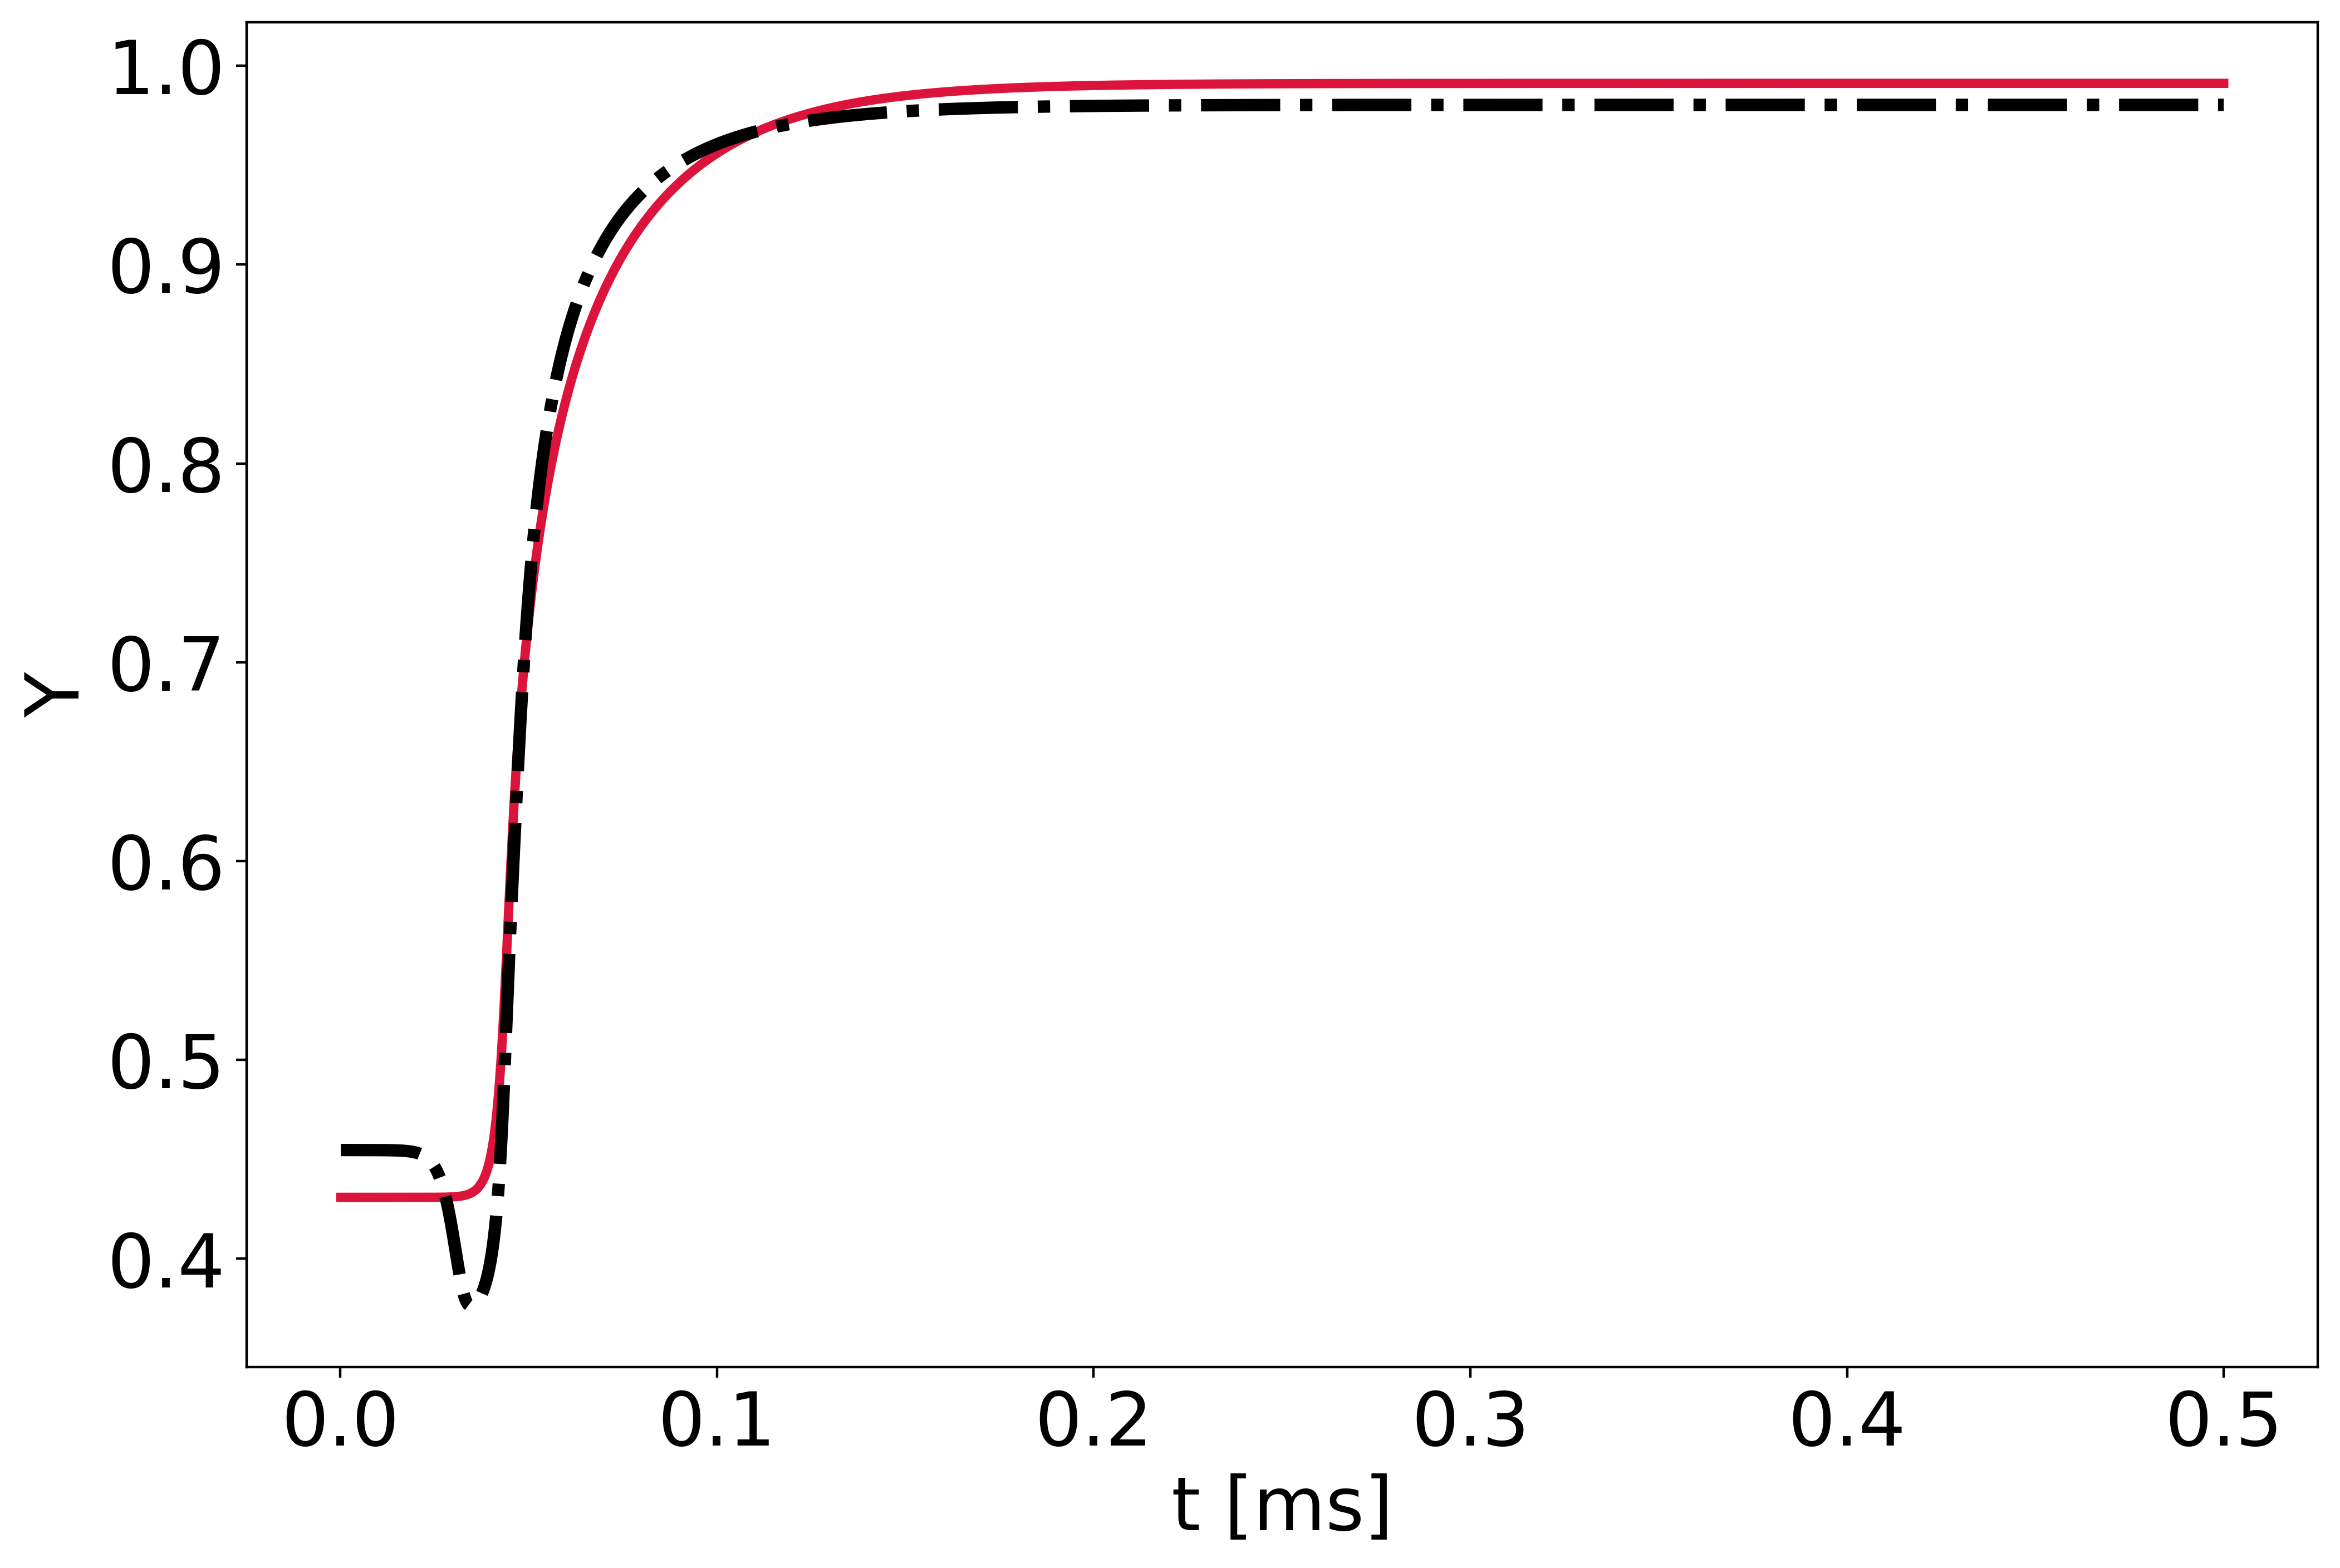

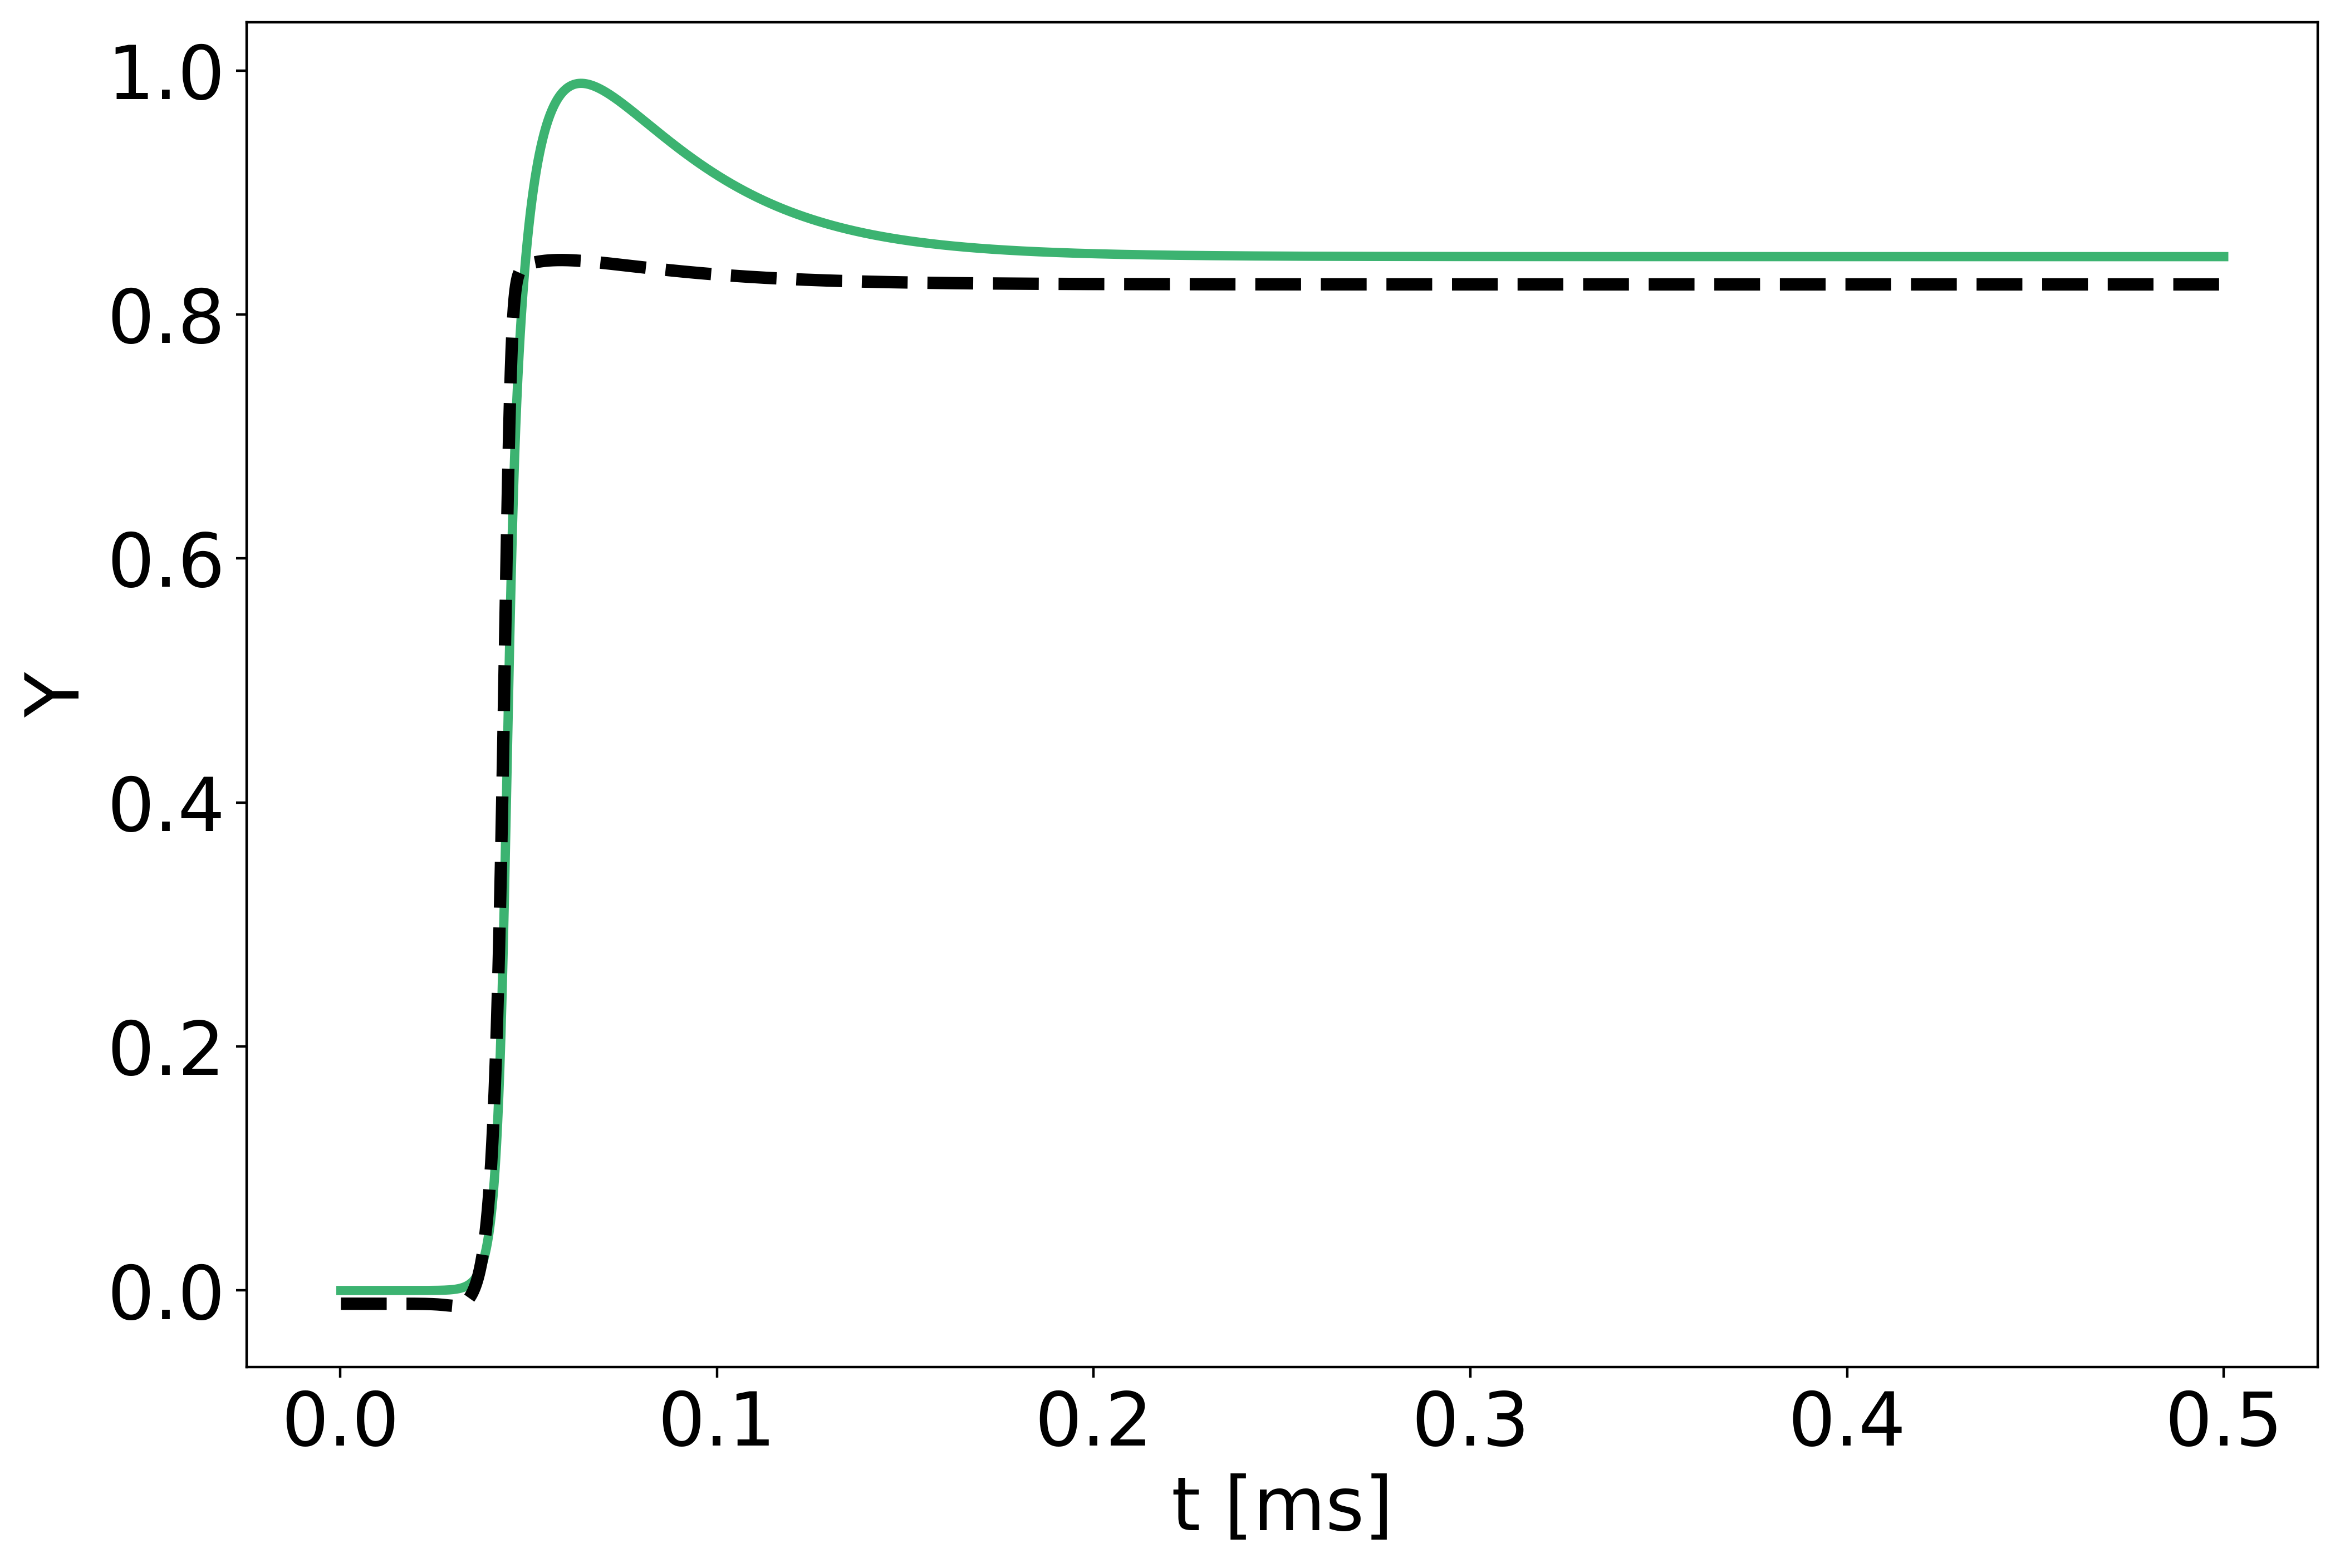

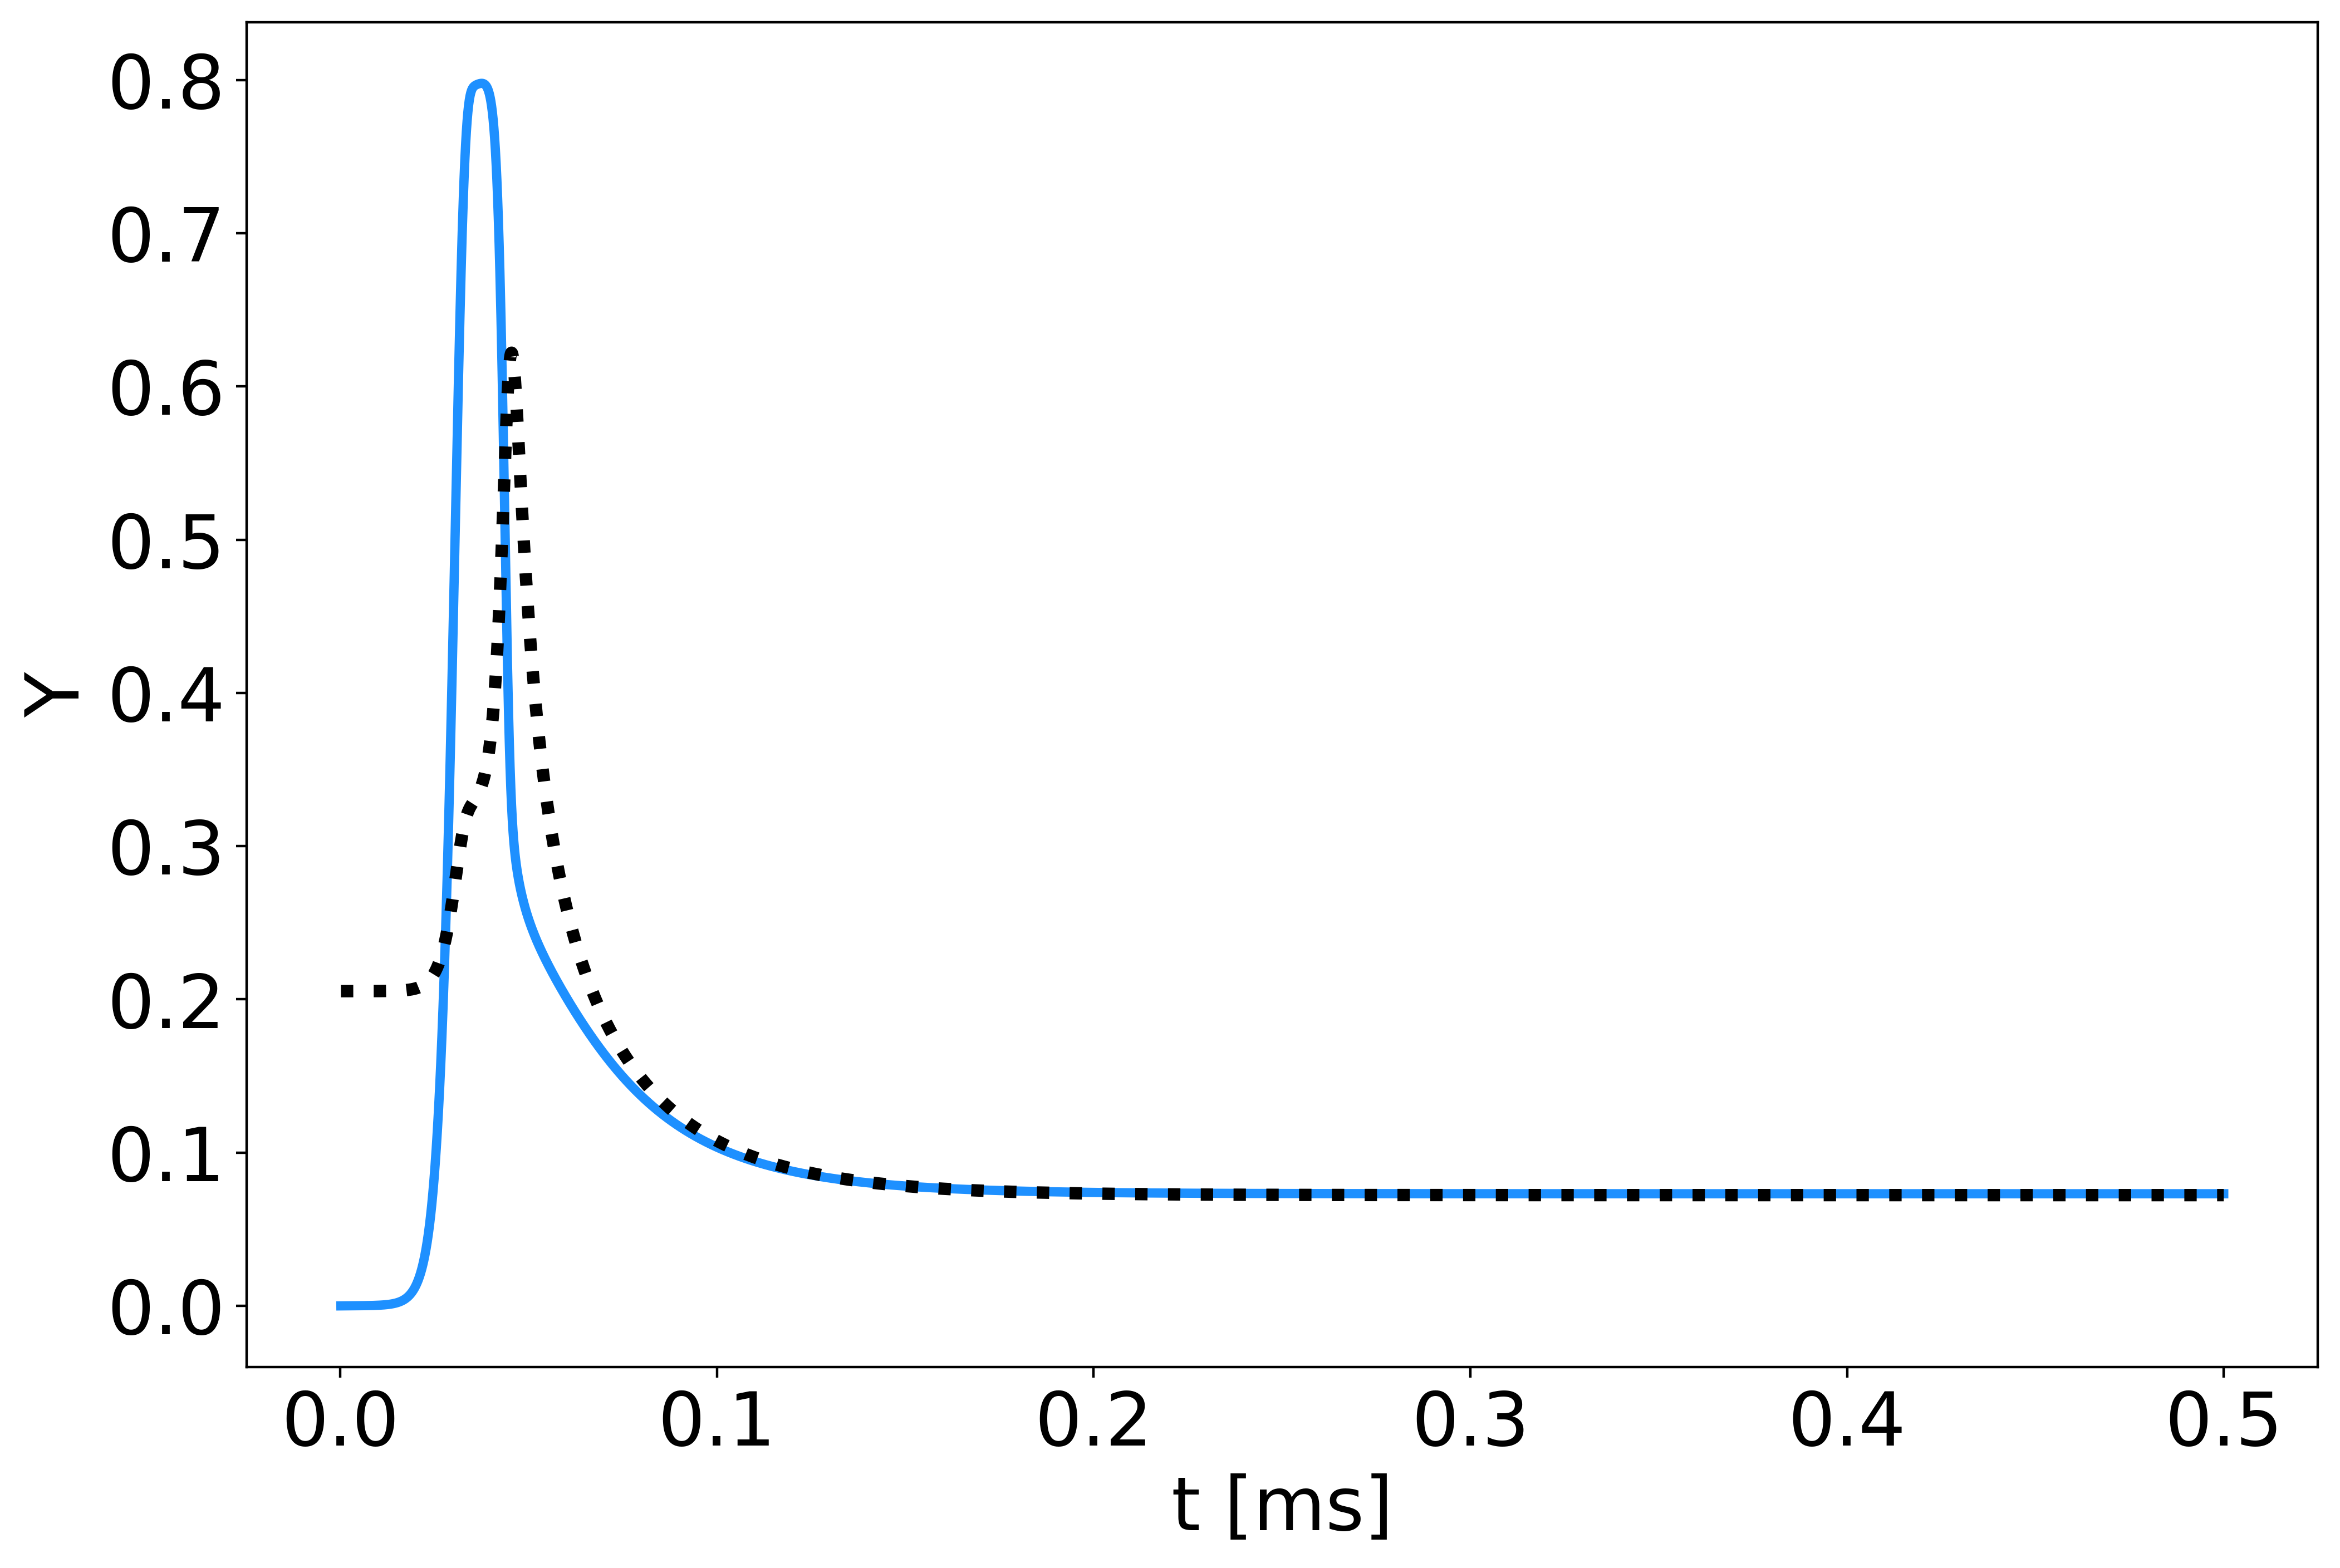

In [12]:
for k in range(len(interest_vector)):
    original_index=columns.index(interest_vector[k]+'shift')
    results_index=columns.index(interest_vector[k]) #minues one due to the time column presence 

    transformation_index=maximum_values.columns.get_loc(interest_vector[k])
    plot_name=interest_vector[k]+'.png'
    
    input_label=interest_vector[k]+' Cantera'
    output_label=interest_vector[k]+' TAE'
    
    original=(dataset.iloc[:,original_index]).to_numpy()
    original=original#*maximum_values.iloc[0,transformation_index]
    
    output=(results[:,results_index-1])
    output=output#*maximum_values.iloc[0,transformation_index]
    
    if interest_vector[k]=='OH':
        color='mediumseagreen'
        linestyle='dashed'
        #color_out=
    if interest_vector[k]=='T[K]':
        color='crimson'
        linestyle='dashdot'
        #color_out=
    if interest_vector[k]=='HO2':
        color='dodgerblue'
        linestyle='dotted'
        #color_out=
    
    plt.figure(k,figsize=(12,8),dpi=400)
    plt.plot(time_plot*1000,original, label=input_label,linewidth=3, color=color)
    plt.plot(time_plot*1000,output, label=output_label,linewidth=4, color='k', linestyle=linestyle)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel('t [ms]', fontsize=24)
    plt.ylabel('Y', fontsize=24)
    #plt.legend(loc='best', fontsize=24)
    plt.savefig(f'normalized_specie_{k}_sandiego_PCA_phi{k1}.jpg',bbox_inches='tight',dpi=400)